In [1]:
import scanpy as sc, numpy as np, pandas as pd
import seaborn as sns
from scipy.stats import median_abs_deviation
import scvi

Global seed set to 0


In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
from matplotlib.pyplot import rc_context
from matplotlib import pyplot as plt

In [ ]:
import os
os.environ["R_HOME"] = "/data/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/R"
os.environ['LD_LIBRARY_PATH'] = "/data/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/R/bin"


import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
print(ro.r(".libPaths()"))

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [5]:
from time import gmtime, strftime
strftime("%Y-%m-%d %H:%M:%S", gmtime())

'2023-12-05 03:17:46'

In [6]:
mainDir = "/mnt/gmi-l1/_90.User_Data/revolvefire/FASTQ"

In [7]:
objectDir = "/mnt/gmi-l1/_90.User_Data/revolvefire/Jupyter/TWIST2_220616/230808_scRNA_new/scobject/"

## Load and prep data

In [ ]:
E13 = sc.read_h5ad(objectDir + "E13_quality_control.h5ad")

E16 = sc.read_h5ad(objectDir + "E16_quality_control.h5ad")

E18_1 = sc.read_h5ad(objectDir + "E18_added_quality_control.h5ad")
E18_2 = sc.read_h5ad(objectDir + "E18_rep_quality_control.h5ad")

PD0_1 = sc.read_h5ad(objectDir + "PD0_1_intron_quality_control.h5ad")
PD0_2 = sc.read_h5ad(objectDir + "PD0_2_intron_quality_control.h5ad")

PD2_1 = sc.read_h5ad(objectDir + "PD2_1_intron_quality_control.h5ad")
PD2_2 = sc.read_h5ad(objectDir + "PD2_2_intron_quality_control.h5ad")

PD4_1 = sc.read_h5ad(objectDir + "PD4_1_intron_quality_control.h5ad")
PD4_3 = sc.read_h5ad(objectDir + "PD4_3_intron_quality_control.h5ad")

In [ ]:
#add orig.ident
E13.obs["orig.ident"] = "E13.5"
E16.obs["orig.ident"] = "E16.5"

E18_1.obs["orig.ident"] = "E18.5_1"
E18_2.obs["orig.ident"] = "E18.5_2"

PD0_1.obs["orig.ident"] = "PD0_1"
PD0_2.obs["orig.ident"] = "PD0_2"

PD2_1.obs["orig.ident"] = "PD2_1"
PD2_2.obs["orig.ident"] = "PD2_2"

PD4_1.obs["orig.ident"] = "PD4_1"
PD4_3.obs["orig.ident"] = "PD4_3"

In [ ]:
#bulk identity
E13.obs["bulk.ident"] = "E13.5"
E16.obs["bulk.ident"] = "E16.5"

E18_1.obs["bulk.ident"] = "E18.5"
E18_2.obs["bulk.ident"] = "E18.5"

PD0_1.obs["bulk.ident"] = "PD0"
PD0_2.obs["bulk.ident"] = "PD0"

PD2_1.obs["bulk.ident"] = "PD2"
PD2_2.obs["bulk.ident"] = "PD2"

PD4_1.obs["bulk.ident"] = "PD4"
PD4_3.obs["bulk.ident"] = "PD4"

In [ ]:
E13 = E13[E13.obs.scDblFinder_class == 'singlet']

In [ ]:
E16 = E16[E16.obs.scDblFinder_class == 'singlet']
E18_1 = E18_1[E18_1.obs.scDblFinder_class == 'singlet']
E18_2 = E18_2[E18_2.obs.scDblFinder_class == 'singlet']
PD0_1 = PD0_1[PD0_1.obs.scDblFinder_class == 'singlet']
PD0_2 = PD0_2[PD0_2.obs.scDblFinder_class == 'singlet']
PD2_1 = PD2_1[PD2_1.obs.scDblFinder_class == 'singlet']
PD2_2 = PD2_2[PD2_2.obs.scDblFinder_class == 'singlet']
PD4_1 = PD4_1[PD4_1.obs.scDblFinder_class == 'singlet']
PD4_3 = PD4_3[PD4_3.obs.scDblFinder_class == 'singlet']

In [ ]:
print(E13)
print(E16)
print(E18_1)
print(E18_2)
print(PD0_1)
print(PD0_2)
print(PD2_1)
print(PD2_2)
print(PD4_1)
print(PD4_3)

In [ ]:
adata =E13.concatenate(E16, E18_1, E18_2, PD0_1, PD0_2, PD2_1, PD2_2, PD4_1, PD4_3)
adata.var_names_make_unique()

In [ ]:
adata

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_hb','pct_counts_ribo'],
             jitter=0.4, multi_panel=False, groupby = "orig.ident")

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', groups="batch")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
#sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
adata = adata[adata.obs.n_genes_by_counts > 1000, 0:]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [ ]:
adata = adata[adata.obs.pct_counts_ribo > 5, 0:]
adata = adata[adata.obs.pct_counts_hb < 1, :]

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.total_counts < 40000, :]
adata = adata[adata.obs.total_counts > 4000, 0:]

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_hb','pct_counts_ribo'],
             jitter=0.4, multi_panel=False, groupby = "orig.ident")

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', groups="batch")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
adata.layers["counts"] = adata.X.copy() # preserve counts for scVI = this is raw count

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata # freeze the state in `.raw`

In [ ]:
adata

In [ ]:
adata.write(objectDir + "231204.adata_lognorm.raw(copy).E13_PD4_mixedrep_strict.h5ad")

In [8]:
adata = sc.read_h5ad(objectDir + "231204.adata_lognorm.raw(copy).E13_PD4_mixedrep_strict.h5ad")

In [9]:
adata

AnnData object with n_obs × n_vars = 67558 × 18859
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'orig.ident', 'bulk.ident', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'n_cells-1', 'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'log1p_total_counts-2', 'n_cells-2', 'n_cells_by_counts-3', 'mean_

In [10]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="orig.ident"
)

In [11]:
adata

AnnData object with n_obs × n_vars = 67558 × 3000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'orig.ident', 'bulk.ident', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'n_cells-1', 'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'log1p_total_counts-2', 'n_cells-2', 'n_cells_by_counts-3', 'mean_c

In [12]:
adata.write(objectDir + "231204.adata.hvg3000.E13_PD4_mixedrep_strict.h5ad")

In [13]:
adata.obs["bulk_ident"] = adata.obs["bulk.ident"]
adata.obs["orig_ident"] = adata.obs["orig.ident"]

## scVI training

In [14]:
scvi.model.SCVI.setup_anndata(adata,
                              layer="counts", categorical_covariate_keys=["bulk_ident", "orig_ident"], continuous_covariate_keys=["pct_counts_mt", "pct_counts_ribo"],
                             ) #mt not included                        
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb") #We note that these parameters are non-default; however, they have been verified to generally work well in the integration task.
vae.train(check_val_every_n_epoch=1) #이게 있어야 validation 체크가 가능함

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 118/118: 100%|██████████| 118/118 [11:41<00:00,  5.70s/it, loss=1.39e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=118` reached.


Epoch 118/118: 100%|██████████| 118/118 [11:41<00:00,  5.95s/it, loss=1.39e+03, v_num=1]


In [15]:
vae.save("231204.E13-PD4.strict.tworepmixed.categoryreflexted.hvg3000.seed0.model")

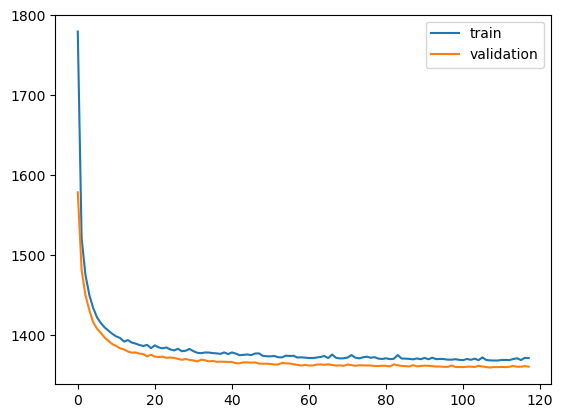

In [16]:
plt.plot(vae.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(vae.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')
plt.legend()

In [18]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [19]:
adata.layers["scvi_normalized"] = vae.get_normalized_expression(
    library_size=10e4
)
adata

AnnData object with n_obs × n_vars = 67558 × 3000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'orig.ident', 'bulk.ident', 'batch', 'bulk_ident', 'orig_ident', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'n_cells-1', 'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'log1p_t

/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/gmi-l

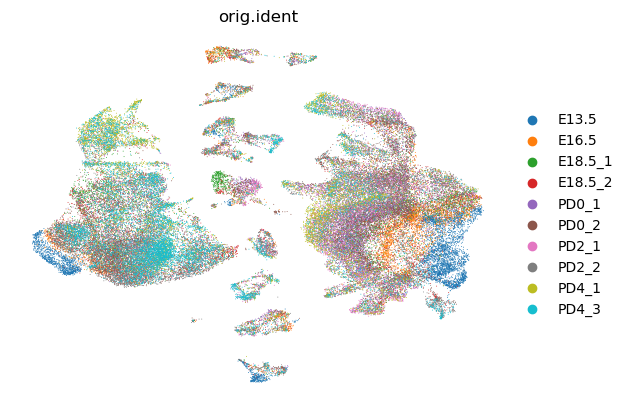

In [20]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color=["orig.ident"],
    frameon=False,
)


/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


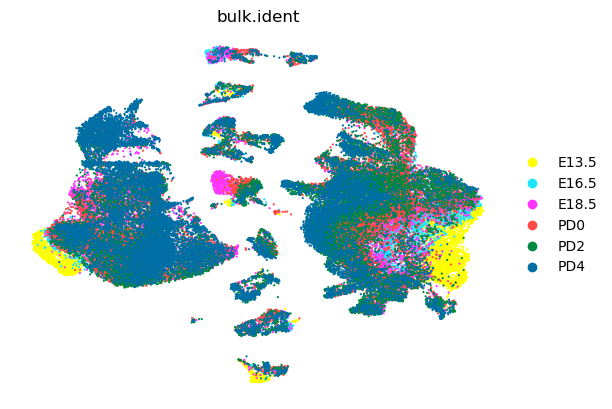

In [21]:
sc.pl.umap(
    adata,
    color=["bulk.ident"],
    frameon=False, palette=sc.pl.palettes.default_102, size=10
)

## Clustering

/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


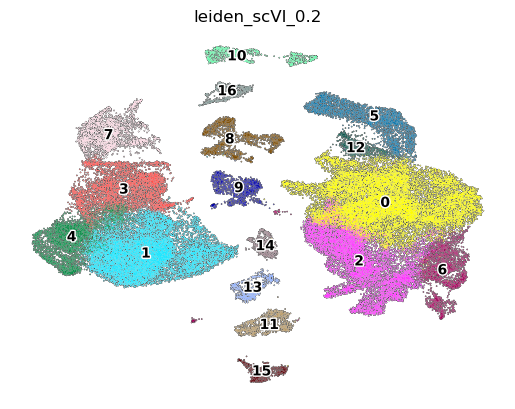

In [25]:
sc.tl.leiden(adata, key_added="leiden_scVI_0.2", resolution=0.2)
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.2"],
    frameon=False, palette=sc.pl.palettes.default_102, add_outline=True, legend_loc='on data',legend_fontoutline=2,
)

/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


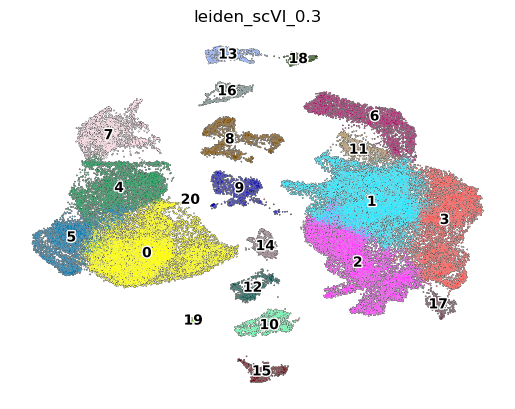

In [26]:
sc.tl.leiden(adata, key_added="leiden_scVI_0.3", resolution=0.3)
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.3"],
    frameon=False, palette=sc.pl.palettes.default_102, add_outline=True, legend_loc='on data',legend_fontoutline=2,
)

/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


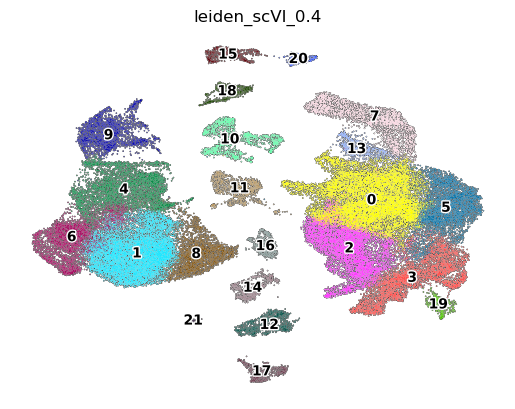

In [27]:
sc.tl.leiden(adata, key_added="leiden_scVI_0.4", resolution=0.4)
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.4"],
    frameon=False, palette=sc.pl.palettes.default_102, add_outline=True, legend_loc='on data',legend_fontoutline=2,
)

/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


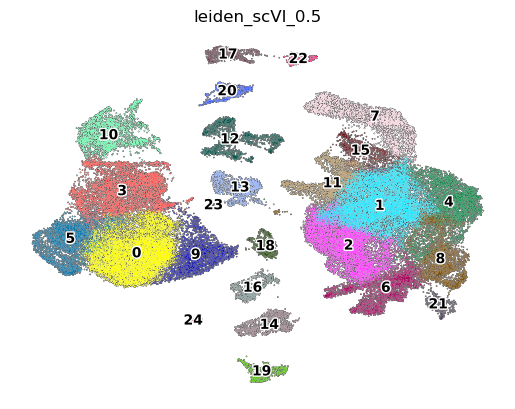

In [28]:
sc.tl.leiden(adata, key_added="leiden_scVI_0.5", resolution=0.5)
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.5"],
    frameon=False, palette=sc.pl.palettes.default_102, add_outline=True, legend_loc='on data',legend_fontoutline=2,
)

/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


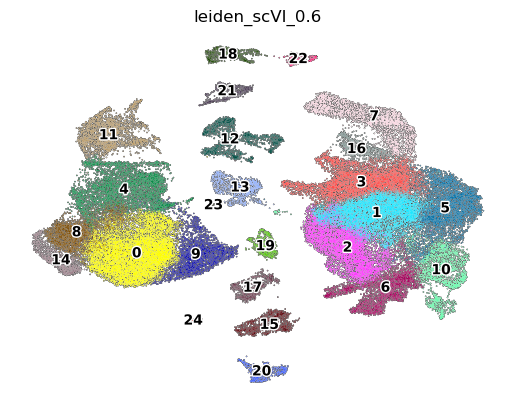

In [29]:
sc.tl.leiden(adata, key_added="leiden_scVI_0.6", resolution=0.6)
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.6"],
    frameon=False, palette=sc.pl.palettes.default_102, add_outline=True, legend_loc='on data',legend_fontoutline=2,
)

/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


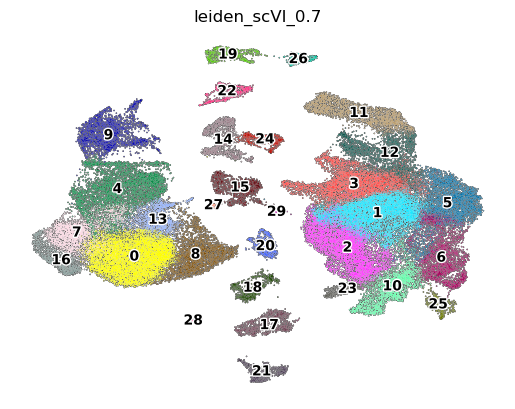

In [30]:
sc.tl.leiden(adata, key_added="leiden_scVI_0.7", resolution=0.7)
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.7"],
    frameon=False, palette=sc.pl.palettes.default_102, add_outline=True, legend_loc='on data',legend_fontoutline=2,
)

/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


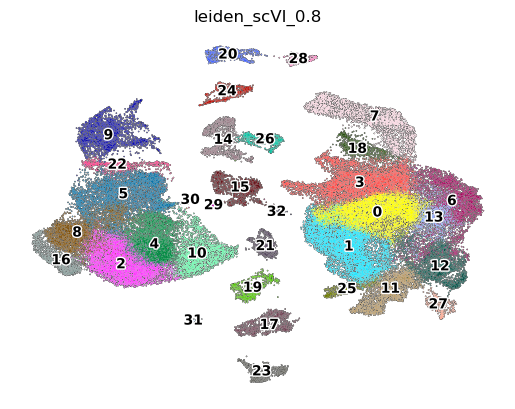

In [31]:
sc.tl.leiden(adata, key_added="leiden_scVI_0.8", resolution=0.8)
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.8"],
    frameon=False, palette=sc.pl.palettes.default_102, add_outline=True, legend_loc='on data',legend_fontoutline=2,
)

/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


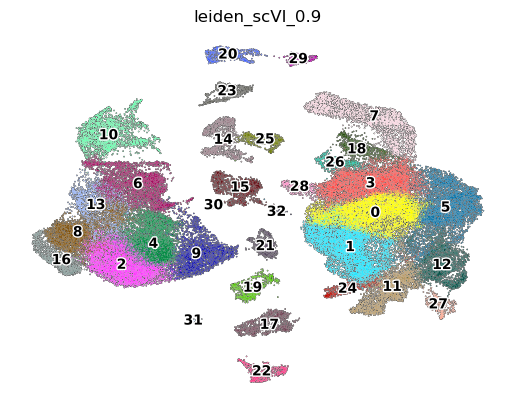

In [32]:
sc.tl.leiden(adata, key_added="leiden_scVI_0.9", resolution=0.9)
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.9"],
    frameon=False, palette=sc.pl.palettes.default_102, add_outline=True, legend_loc='on data',legend_fontoutline=2
)

In [28]:
sc.tl.leiden(adata, restrict_to=('leiden_scVI_0.9', ['7']), resolution=0.1, key_added='sub_cluster')

/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/mambaforge/envs/master_cuda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


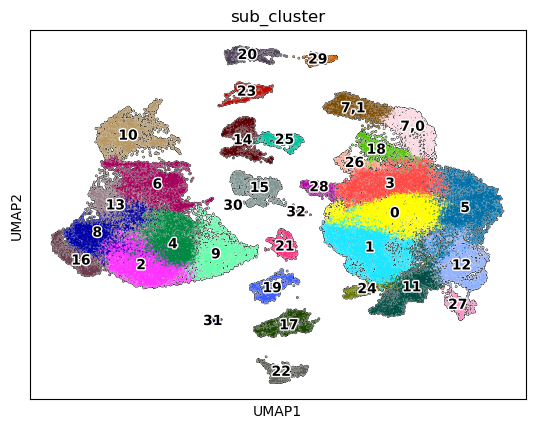

In [29]:
sc.pl.umap(adata, color='sub_cluster', add_outline=True, size=5, legend_loc='on data',legend_fontoutline=2)